# > VAE model trained on the *MNIST* dataset

In [1]:
from keras.layers import Input, Dense, Lambda, Flatten
from keras.losses import BinaryCrossentropy
from keras.models import Model
from keras.callbacks import TensorBoard
from keras import backend as K
import tensorflow as tf

from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
x = Input(batch_shape=(batch_size, original_dim))
# print(x.shape)
# x = Flatten()(x)
# print(x.shape)
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma]) # alternatively : `Lambda(sampling)([z_mean, z_log_sigma])`

In [5]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [6]:
vae = Model(x, x_decoded_mean)

encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [7]:
binary_crossentropy = BinaryCrossentropy(from_logits=True)

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [13]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [14]:
vae.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_variational',
                                       histogram_freq=0, write_graph=False)])
'''
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
                '''

Epoch 1/100


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 329, in __call__
        self._total_loss_mean.update_state(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 509, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/keras_tensor.py", line 285, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_8'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['input_2[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                            

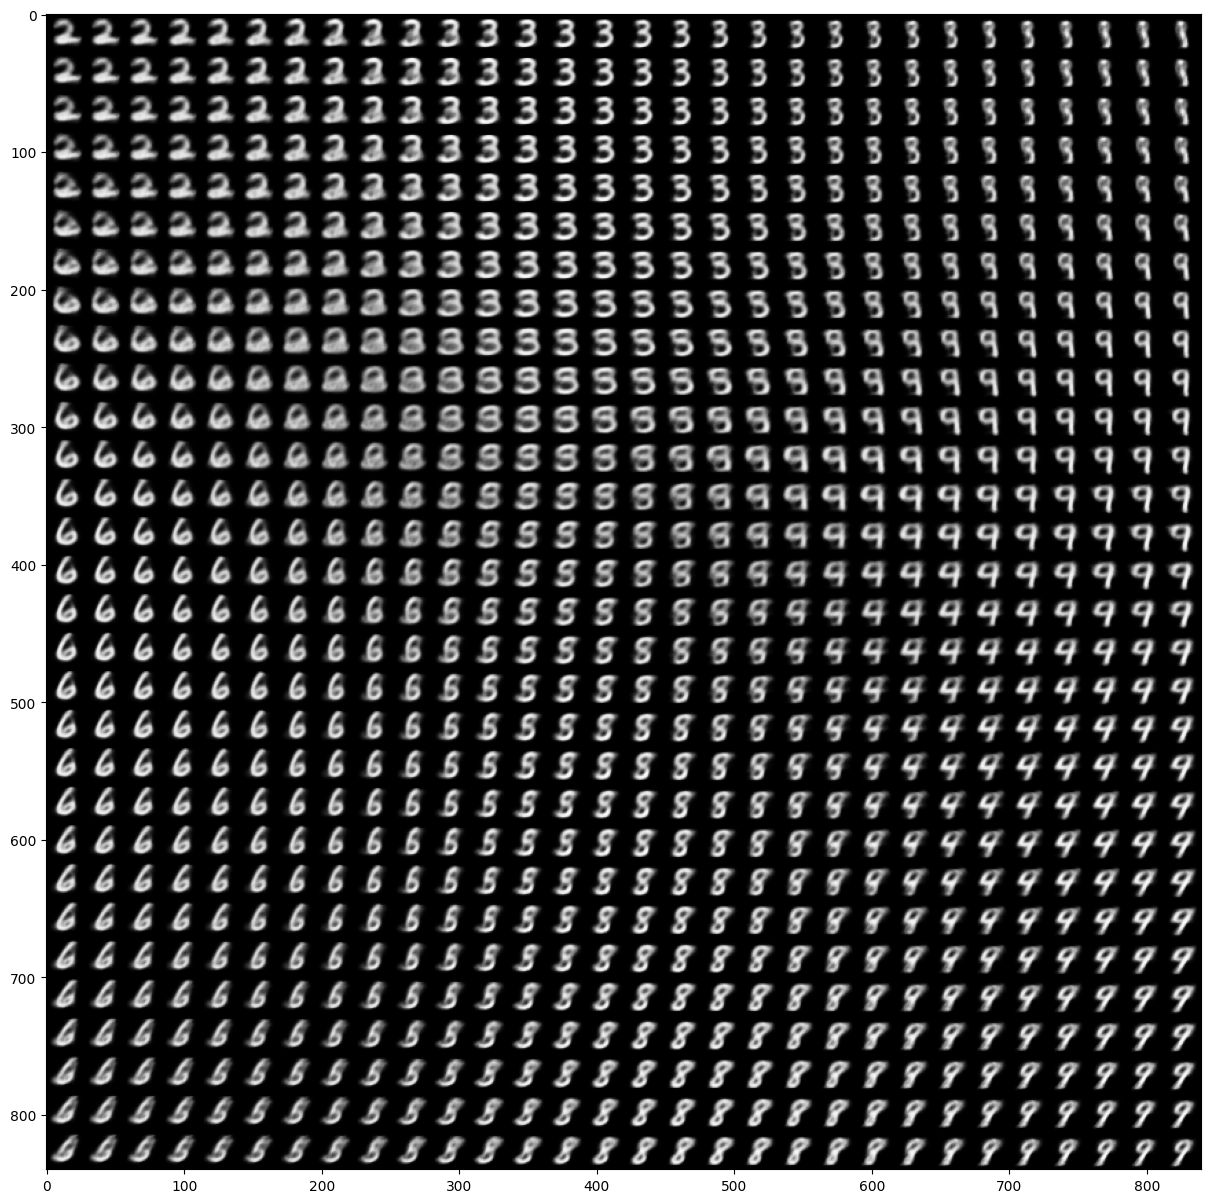

In [3]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape the data
original_dim = 28 * 28
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# VAE model parameters
input_shape = (original_dim,)
intermediate_dim = 512
latent_dim = 2
# VAE model architecture
# Encoder
inputs = tf.keras.Input(shape=input_shape)
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Sampling function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.exp(z_log_sigma) * epsilon

# Use Lambda layer for sampling
z = Lambda(sampling)([z_mean, z_log_sigma])

# Encoder model
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# Decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
# Loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile and train the model
vae.compile(optimizer='adam')
vae.summary()

# Train the VAE
vae.fit(x_train, x_train,
        epochs=50,
        batch_size=256,
        validation_data=(x_test, x_test))
# Display a 2D plot of the digit classes in the latent space
def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

plot_latent_space(vae)

# ... trained on **CIFAR10 dataset**